In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md
_nb_loc = "03_image_models/03d_finetune_VGG19_flowers104.ipynb" # change to reflect your notebook
_nb_title = "Fine-tuning VGG16 on 104 flowers (image classification)" # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Fine-tuning+VGG16+on+104+flowers+%28image+classification%29&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F03_image_models%2F03d_finetune_VGG19_flowers104.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/03_image_models/03d_finetune_VGG19_flowers104.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/03_image_models/03d_finetune_VGG19_flowers104.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/03_image_models/03d_finetune_VGG19_flowers104.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 104 Flowerデータセットを使用したVGG16のファインチューニング(画像分類)  
このノートブックは、TPUまたはGPUで実行するように設定されています。GPUでは実行に時間がかかるため、特にTPUv3での実行を推奨しています。

以下のパラメータはTPUv3での実行用に設定されていますので、**TPUv2(Colab)やGPUなど、メモリの少ないハードウェアで実行した場合、`ResourceExhaustedError`が出ることがあります。その際は以下の[設定]セクションでバッチサイズ(`BATCH_SIZE`)やイメージサイズ(`IMAGE_SIZE`)を小さく設定してください。**

Vertex AI WorkbenchやColabでTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.AUTOTUNE

Tensorflow version 2.8.0


# TPUまたはGPUの検出

In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# 設定

Learning rate schedule: 1e-05 to 0.0004 to 1.66e-05


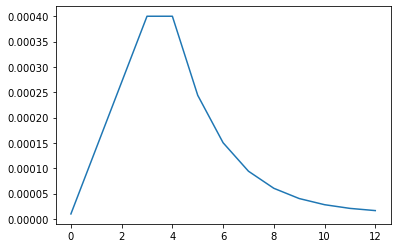

In [4]:
GCS_DS_PATH = "gs://practical-ml-vision-book/flowers_104_tfr"

# Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [331, 331] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 13

# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 1
LR_EXP_DECAY = .6

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

# This dataset is split three ways, training, validation, test
# but we will use it split two ways only: training and validation.
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
VALIDATION_FILENAMES =  tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## 可視化のためのヘルパー関数
可視化用に様々なヘルパー関数を定義しておきます。

In [5]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# データセット

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum = example['id'] # image id, not used
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16465 training images, 7382 validation images


# データセットの可視化

In [8]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

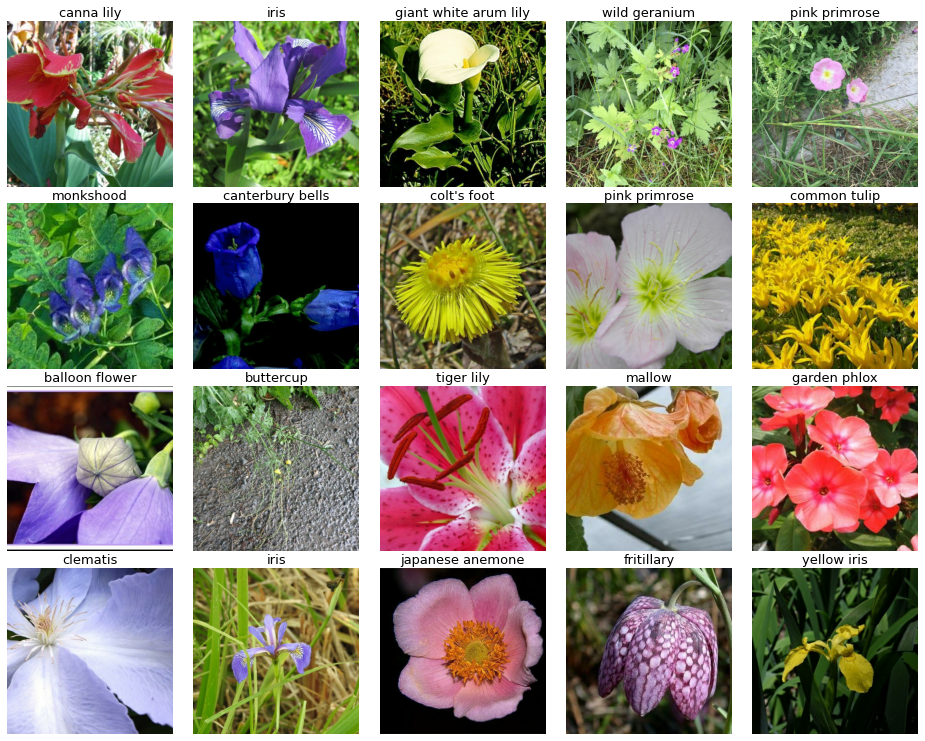

In [9]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

# モデル

In [10]:
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.vgg19.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax', name='flower_prob')
    ])
    
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 331, 331, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 10, 10, 512)       20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flower_prob (Dense)         (None, 104)               53352     
                                                                 
Total params: 20,077,736
Trainable params: 20,077,736
Non-trainable params: 0
_________________________________________________________________


# トレーニング

In [11]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
64/64 [==============================] - 47s 741ms/step - loss: 4.6975 - sparse_categorical_accuracy: 0.0338 - val_loss: 4.2669 - val_sparse_categorical_accuracy: 0.0841 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.00014.
Epoch 2/13
64/64 [==============================] - 19s 298ms/step - loss: 2.9744 - sparse_categorical_accuracy: 0.3453 - val_loss: 1.7102 - val_sparse_categorical_accuracy: 0.6069 - lr: 1.4000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00027.
Epoch 3/13
64/64 [==============================] - 19s 300ms/step - loss: 1.3315 - sparse_categorical_accuracy: 0.6720 - val_loss: 1.0210 - val_sparse_categorical_accuracy: 0.7539 - lr: 2.7000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0004.
Epoch 4/13
64/64 [==============================] - 19s 300ms/step - loss: 1.1034 - sparse_categorical_accuracy: 0.7173 - val_loss: 1.0023 - val_

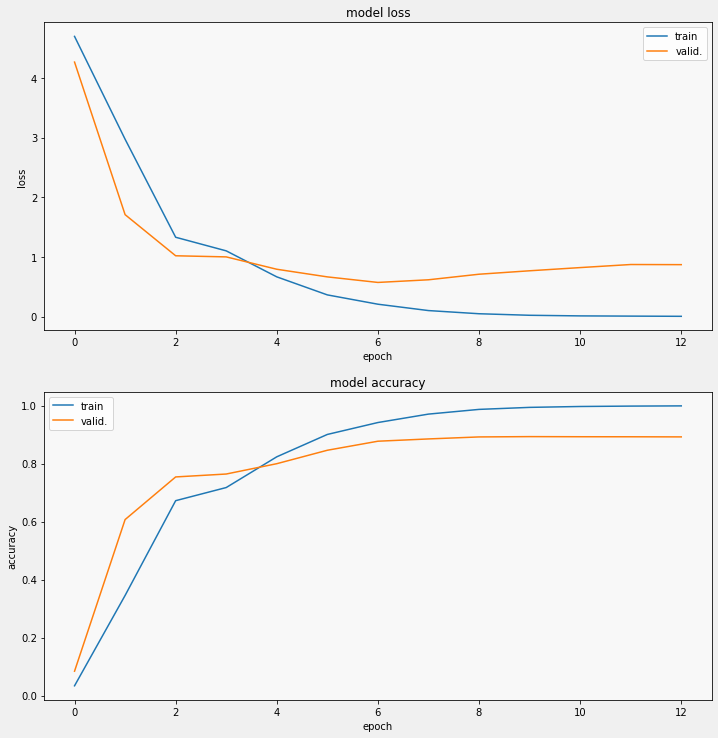

In [12]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, zoom_pcent=95)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


# 混同行列

In [13]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (7382,) [ 67  28  83 ...  95 102  62]
Predicted labels:  (7382,) [ 67  28  86 ...  53 102  62]


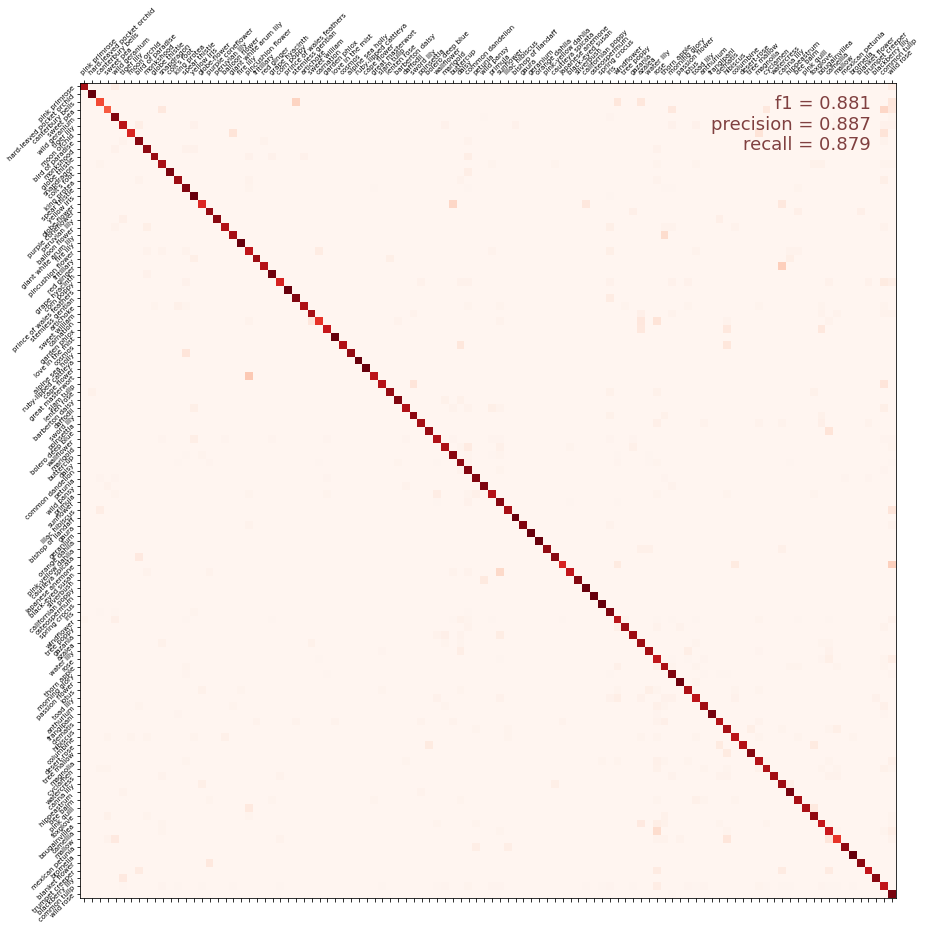

f1 score: 0.881, precision: 0.887, recall: 0.879


In [14]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# 可視化による検証

In [15]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

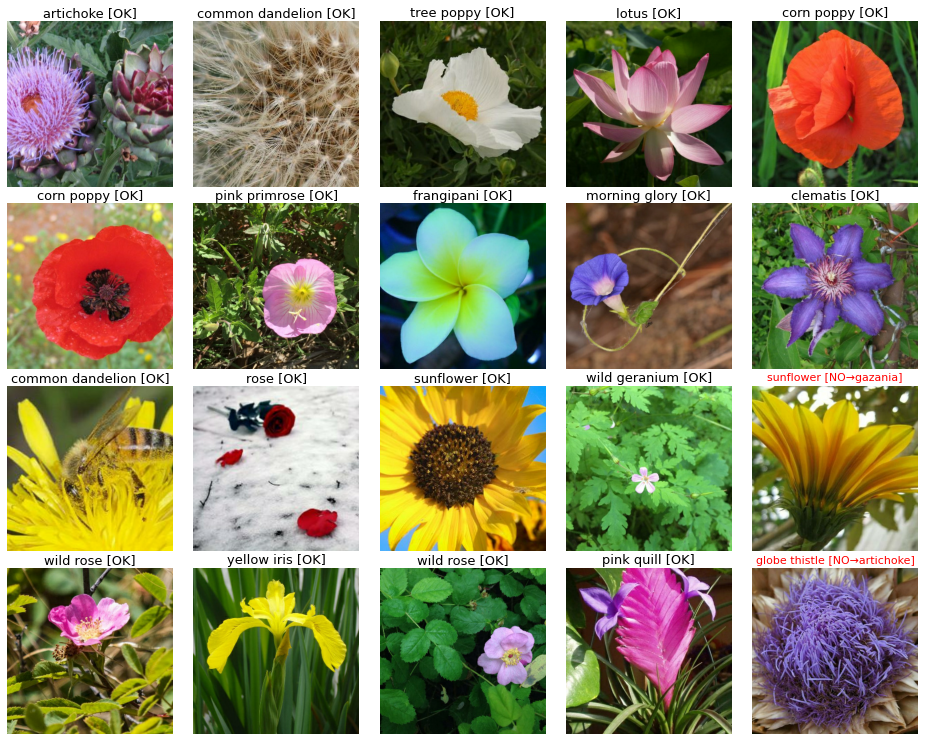

In [16]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.